In [101]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

**Dataset from kaggle**

In [102]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-03 18:19:47--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.7’

laptops.csv.7       100%[===================>] 291.58K  --.-KB/s    in 0.01s   

2024-10-03 18:19:47 (24.7 MB/s) - ‘laptops.csv.7’ saved [298573/298573]



In [103]:
df = pd.read_csv('laptops.csv')

**Dataset preparation - normalization of columns**

In [104]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

**filtering columns for needed features**

In [105]:
df = df[['ram',
        'storage',
        'screen',
        'final_price'
        ]]

In [106]:
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


**Check if final_price has a long tail**

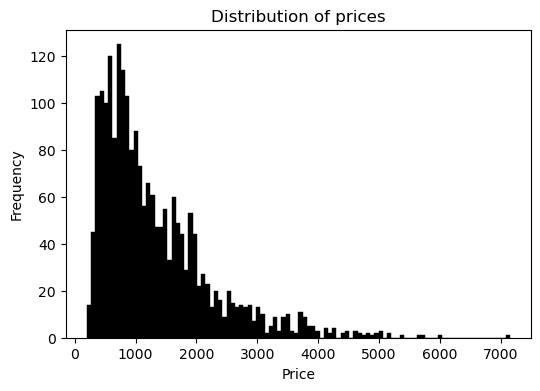

In [107]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=100, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

**It has a long tail**

**Question 1
There's one column with missing values. What is it?
'ram'
'storage'
'screen'
'final_price'**

In [108]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

**Question 2
What's the median (50% percentile) for variable 'ram'?
8
16
24
32**

In [109]:
df.ram.median()

16.0

**Prepare and split the dataset.**

***Shuffle the dataset (the filtered one), use seed 42.**

***Split data in train/val/test sets, with 60%/20%/20% distribution.**

In [110]:
np.random.seed(42)

n = len(df)

#20%
n_val = int(0.2 * n) 
#20%
n_test = int(0.2 * n) 
#60%
n_train = n - (n_val + n_test) 

#create index and shuffle it.
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

**Question 3**

**fill missing values for the column from Q1.**

**two options: fill it with 0 or with the mean of this variable.**

**Try both options. For each, train a linear regression model without regularization**

**Use the validation dataset to evaluate the models and compare the RMSE of each option.**

**Round the RMSE scores to 2 decimal digits using round(score, 2)**

**Which option gives better RMSE?**


**Dataframe fill empty values with 0**

In [111]:
df_filled_with_zeros = df.fillna(0).copy()

In [112]:
df_filled_with_zeros.isnull().sum()

ram            0
storage        0
screen         0
final_price    0
dtype: int64

**Dataframe fill empty values of train dataset with mean**

In [113]:
df_filled_with_mean = df.fillna(df_train.mean()).copy()

In [114]:
df_filled_with_mean.isnull().sum()

ram            0
storage        0
screen         0
final_price    0
dtype: int64

**Check that the original dataframe wasn't modified**

In [115]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

**Training with linear regression**

In [116]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [117]:
w_0, w = train_linear_regression(df_train, y_train)

In [118]:
y_pred = w_0 + df_train.dot(w)

In [121]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [122]:
rmse(y_train, y_pred)

nan